# Monitoramento de casos de CVID19 no Brasil.

**Este notebook tem como objetivo aplicar técnicas de análise da dados, somente para fins didáticos.**

### INFORMAÇÕES SOBRE AS BASES UTILIZADAS

* Base utilizada para extrair dados do Brasil e Estados [G1  Globo](https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/27/casos-de-coronavirus-no-brasil-em-27-de-marco.ghtml) Fonte: Ministério da Saúde até 15 de março; secretarias estaduais da Saúde a partir de 16 de março.Criado com Datawrapper

* Base utilizada para extrair dados dos Municipios [brasil.io](https://brasil.io/dataset/covid19/caso) Boletins informativos baseado no Ministério da Saúde e secretarias estaduais da Saúde.

* Base utilizada para extrair dados dos Mundial  [BNO News]( https://bnonews.com/index.php/2020/03/the-latest-coronavirus-cases ) Boletins informativos baseado nos dados da OMS.

* Base utilizada para extrair dados dos Mundial [OMS]( https://who.sprinklr.com)OMS.

* Base utilizada para extrair dados dos Estados [Ministério da Saúde]( https://covid.saude.gov.br/ )

*Nenhuma copia deste notebook é permitida sem citar a fonte original.*

In [1]:
#!pip install matplotlib

In [48]:
import pandas as pd
import numpy as np
import cufflinks as cf
import wget
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import folium
from folium.plugins import Search
import os
import requests
import json
from pandas.io.json import json_normalize
from folium import plugins
from numpy import nan as NA
from plotly.offline import iplot
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
cf.go_offline()
plotly.offline.init_notebook_mode(connected=True)

## Carregamento e Tratamento dos Dados

In [3]:

################################downloads######################################################### 
url_brasil_io = 'https://brasil.io/dataset/covid19/caso?format=csv'
if os.path.exists('DB/api_br_io.csv'):
    os.remove('DB/api_br_io.csv')
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
else:
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
################################################################################################### 
#A URL muda diariamente 
url_ministerio_saude = ('https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/2995b8dbd2134cc15a50d3eef3240b71_Download_COVID19_20200429.csv')
if os.path.exists('DB/ministerio_saude.csv'):
    os.remove('DB/ministerio_saude.csv')
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')
else:
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')



100% [..............................................................................] 80110 / 80110

In [167]:
###############################read_csv######################################################### 
estados = pd.read_csv('DB/estados.csv', encoding='utf-8')
municipios = pd.read_csv('DB/municipios.csv', encoding='utf-8')
api_br_io = pd.read_csv('DB/api_br_io.csv')
api_br_io = api_br_io.fillna(0)
api_br_io.city_ibge_code = api_br_io.city_ibge_code.astype('int64')
url_estados = 'DB/estados.json'
cidades = pd.read_json(url_estados)
municipios_map = json_normalize(cidades.features)  
casos = pd.read_csv('DB/ministerio_saude.csv', sep=';', encoding='cp1252')

########################################################################

C:\Users\joner\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [168]:
#renomeando colunas
municipios.columns = ['city_ibge_code','city','latitude','longitude','capital','uf_code']
casos.columns = ['regiao','sigla','data','casosNovos','casosAcumulados','obitosNovos','obitosAcumulados']

#tratando nomes para fazer o merge
estados = estados[['uf', 'nome']]
estados.columns = ['state','state_name']
cidades = api_br_io.merge(municipios.drop('uf_code', axis=1), on=['city','city_ibge_code'], how='left')
cidades = cidades.merge(estados, on='state', how='left')

cidades = cidades[(cidades.is_last==True) & (cidades.city !='Importados/Indefinidos')]
dadosCidades = cidades[ cidades.latitude.notnull() ]
cidades = dadosCidades[dadosCidades.place_type == 'city']
estados_brasil = dadosCidades[dadosCidades.capital == 1.0]
saude = pd.DataFrame(casos)


,date,state,city,place_type,confirmed,deaths,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,latitude,longitude,capital,state_name
0,2020-04-30,AL,Anadia,city,1,1,True,17545.0,2700201,5.69963,1.0,-9.68489,-36.3078,0.0,Alagoas
1,2020-04-30,AL,Arapiraca,city,18,0,True,231747.0,2700300,7.76709,0.0,-9.75487,-36.6615,0.0,Alagoas
2,2020-04-30,AL,Atalaia,city,1,0,True,47185.0,2700409,2.11932,0.0,-9.51190,-36.0086,0.0,Alagoas
3,2020-04-30,AL,Barra de Santo Antônio,city,1,0,True,15932.0,2700508,6.27668,0.0,-9.40230,-35.5101,0.0,Alagoas
4,2020-04-30,AL,Barra de São Miguel,city,4,0,True,8322.0,2700607,48.06537,0.0,-9.83842,-35.9057,0.0,Alagoas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3928,2020-04-28,SE,Rosário do Catete,city,1,1,True,10855.0,2806107,9.21234,1.0,-10.69040,-37.0357,0.0,Sergipe
3929,2020-04-28,SE,São Cristóvão,city,6,0,True,90072.0,2806701,6.66134,0.0,-11.00840,-37.2044,0.0,Sergipe
3930,2020-04-28,SE,Simão Dias,city,5,1,True,40484.0,2807105,12.35056,0.2,-10.73870,-37.8097,0.0,Sergipe
3931,2020-04-28,SE,Tomar do Geru,city,1,0,True,13536.0,2807501,7.38771,0.0,-11.36940,-37.8433,0.0,Sergipe


### Criando dados gerais do Brasil

In [51]:
dados = saude.copy()
dadoslimpo = dados.dropna()
dadoslimpo['casosNovos'] = pd.to_numeric(dadoslimpo['casosNovos'])
dadoslimpo['obitosNovos'] = pd.to_numeric(dadoslimpo['obitosNovos'])
dadoslimpo['casosAcumulados'] = pd.to_numeric(dadoslimpo['casosAcumulados'])
dadoslimpo['obitosAcumulados'] = pd.to_numeric(dadoslimpo['obitosAcumulados'])
#dadoslimpo['data'] = pd.to_datetime(dadoslimpo['data'], format='%d-%m-%Y')

casosNovosDia = dadoslimpo['casosNovos'].groupby(dadoslimpo['data']).sum()
casosNovosDia = casosNovosDia[(casosNovosDia.index >= '2020-02-26')].reset_index()

obitosNovosDia = dadoslimpo['obitosNovos'].groupby(dadoslimpo['data']).sum()
obitosNovosDia = obitosNovosDia[(obitosNovosDia.index >= '2020-02-26')].reset_index()

casosNovos = dadoslimpo['casosNovos'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
casosNovos = casosNovos[casosNovos>=0].reset_index().drop('data',axis=1)

obitosNovos = dadoslimpo['obitosNovos'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
obitosNovos = obitosNovos[obitosNovos>=0].reset_index().drop('data',axis=1)

mortesTotal = dadoslimpo['obitosAcumulados'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
mortesTotal = mortesTotal[(mortesTotal.index >= '2020-02-26')].reset_index()

casosTotal = dadoslimpo['casosAcumulados'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
casosTotal = casosTotal[(casosTotal.index >= '2020-02-26')].reset_index()


In [52]:
teste = dadoslimpo[['casosAcumulados','data']].groupby(dadoslimpo['data']).sum()


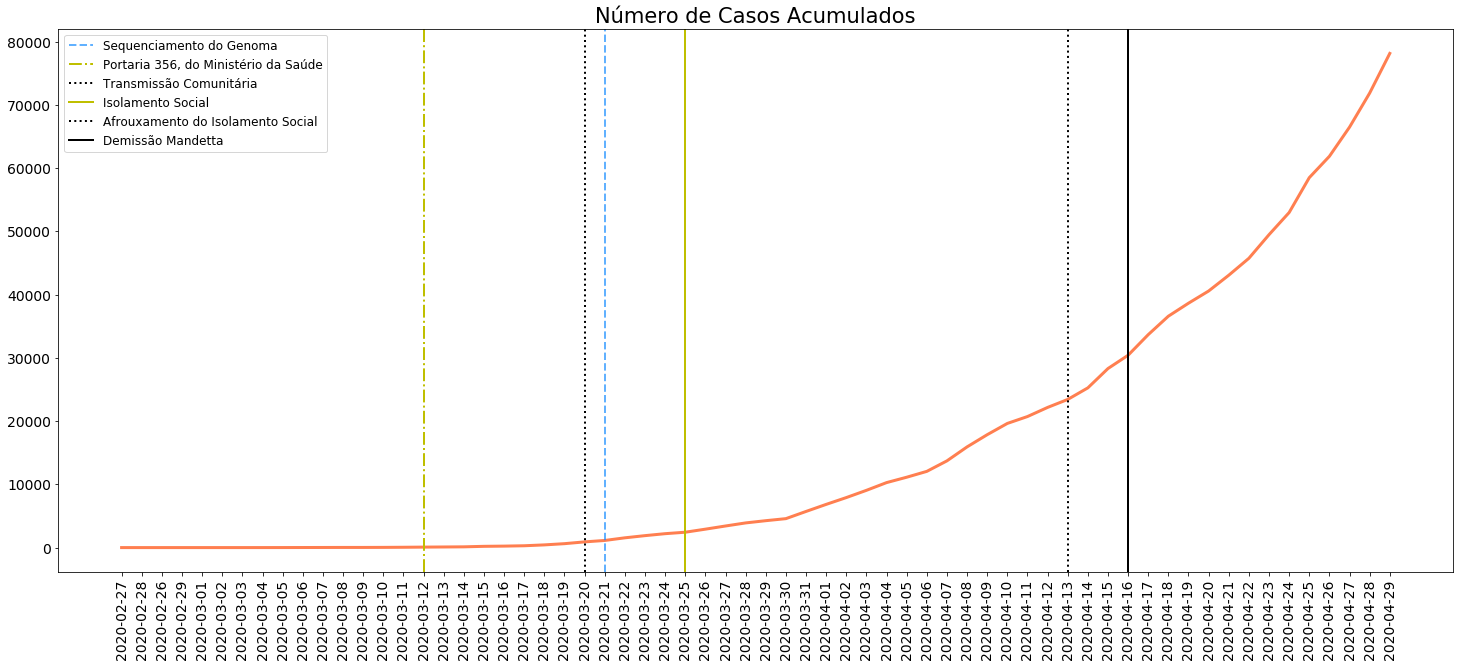

In [53]:

plt.figure(figsize=(25, 10))
plt.plot(casosTotal.data, casosTotal['casosAcumulados'].to_numpy(), linewidth=3, color='coral', label=None)
plt.xticks(casosTotal.data, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Número de Casos Acumulados', fontsize=21)

plt.axvline('2020-03-21', 0, 8000, color='dodgerblue', linestyle='--', linewidth=2, alpha=0.7, label='Sequenciamento do Genoma')
plt.axvline('2020-03-12', 0, 8000, color='y', linestyle='-.', linewidth=2, alpha=1, label='Portaria 356, do Ministério da Saúde')
plt.axvline('2020-03-20', 0, 8000, color='k', linestyle='dotted', linewidth=2, alpha=1, label='Transmissão Comunitária')
plt.axvline('2020-03-25', 0, 8000, color='y', linestyle='-', linewidth=2, alpha=1, label='Isolamento Social')
plt.axvline('2020-04-13', 0, 8000, color='k', linestyle=':', linewidth=2, alpha=1, label='Afrouxamento do Isolamento Social')
plt.axvline('2020-04-16', 0, 8000, color='k', linestyle='-', linewidth=2, alpha=1, label='Demissão Mandetta')
 
plt.legend(loc=2, fancybox=True, fontsize=12)
plt.show()

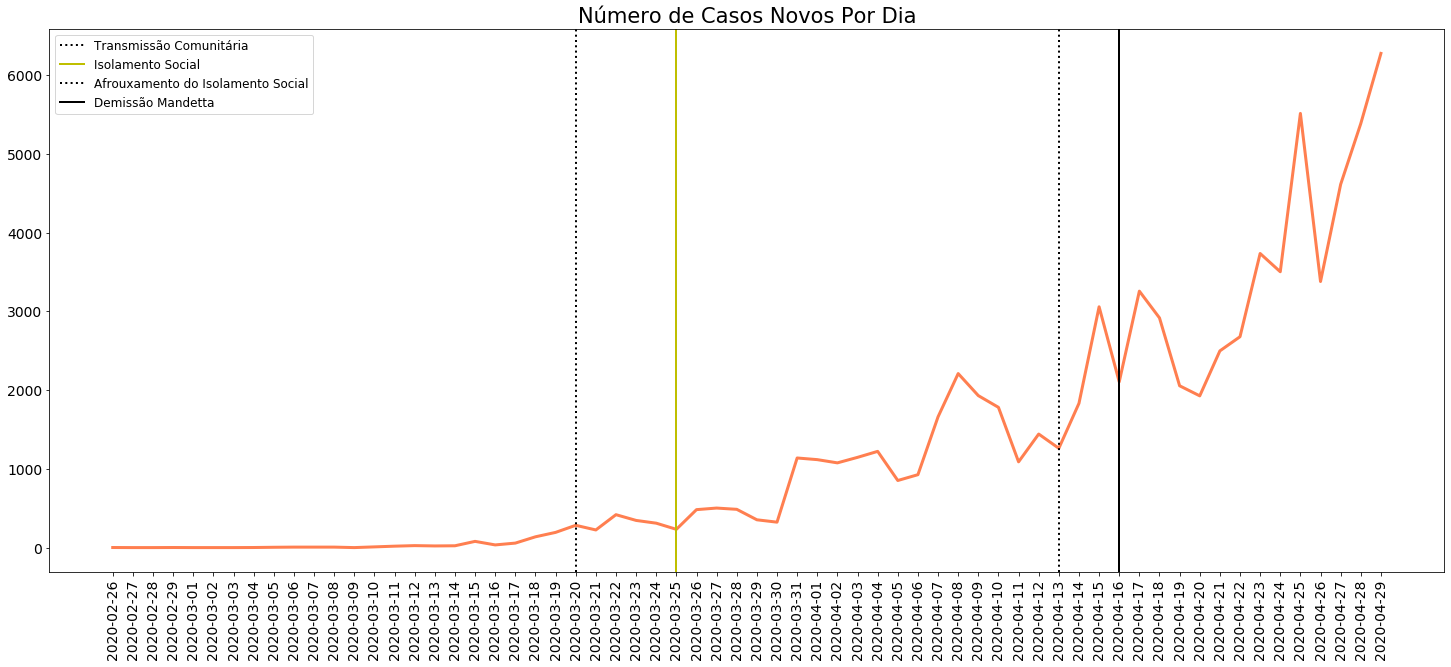

In [54]:
plt.figure(figsize=(25, 10))
plt.plot(casosNovosDia.data, casosNovosDia['casosNovos'].to_numpy(), linewidth=3, color='coral', label=None)
plt.xticks(casosNovosDia.data, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
#plt.axvline('2020-03-21', 0, 8000, color='dodgerblue', linestyle='--', linewidth=2, alpha=0.7, label='Sequenciamento do Genoma')
#plt.axvline('2020-03-12', 0, 8000, color='y', linestyle='-.', linewidth=2, alpha=1, label='Portaria 356, do Ministério da Saúde')
plt.axvline('2020-03-20', 0, 8000, color='k', linestyle='dotted', linewidth=2, alpha=1, label='Transmissão Comunitária')
plt.axvline('2020-03-25', 0, 8000, color='y', linestyle='-', linewidth=2, alpha=1, label='Isolamento Social')
plt.axvline('2020-04-13', 0, 8000, color='k', linestyle=':', linewidth=2, alpha=1, label='Afrouxamento do Isolamento Social')
plt.axvline('2020-04-16', 0, 8000, color='k', linestyle='-', linewidth=2, alpha=1, label='Demissão Mandetta')
plt.title('Número de Casos Novos Por Dia', fontsize=21) 
plt.legend(loc=2, fancybox=True, fontsize=12)
plt.show()

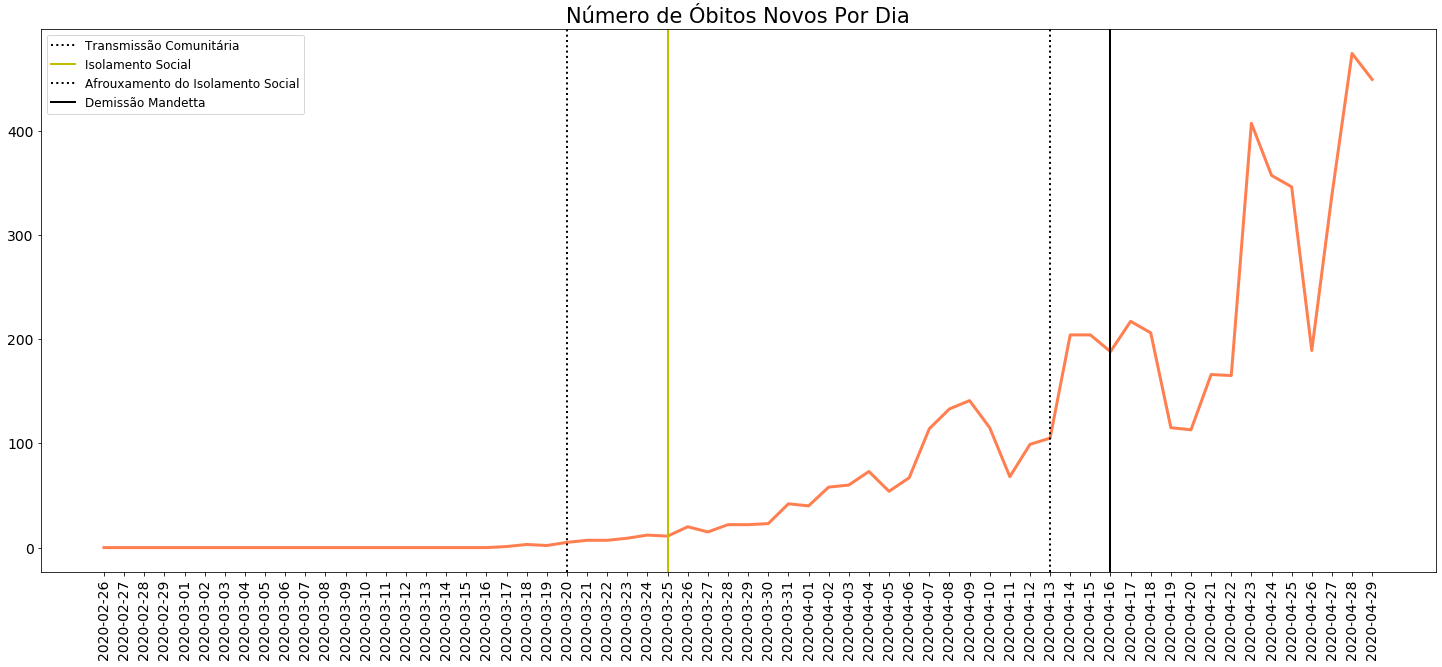

In [55]:
plt.figure(figsize=(25, 10))
plt.plot(obitosNovosDia.data, obitosNovosDia['obitosNovos'].to_numpy(), linewidth=3, color='coral', label=None)
plt.xticks(obitosNovosDia.data, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
#plt.axvline('2020-03-21', 0, 8000, color='dodgerblue', linestyle='--', linewidth=2, alpha=0.7, label='Sequenciamento do Genoma')
#plt.axvline('2020-03-12', 0, 8000, color='y', linestyle='-.', linewidth=2, alpha=1, label='Portaria 356, do Ministério da Saúde')
plt.axvline('2020-03-20', 0, 8000, color='k', linestyle='dotted', linewidth=2, alpha=1, label='Transmissão Comunitária')
plt.axvline('2020-03-25', 0, 8000, color='y', linestyle='-', linewidth=2, alpha=1, label='Isolamento Social')
plt.axvline('2020-04-13', 0, 8000, color='k', linestyle=':', linewidth=2, alpha=1, label='Afrouxamento do Isolamento Social')
plt.axvline('2020-04-16', 0, 8000, color='k', linestyle='-', linewidth=2, alpha=1, label='Demissão Mandetta')
plt.title('Número de Óbitos Novos Por Dia', fontsize=21) 
plt.legend(loc=2, fancybox=True, fontsize=12)
plt.show()

# Gráficos Brasil

In [56]:
from datetime import datetime
now = datetime.now()
fig1 = go.Figure(
    [
        go.Scatter(x = casosTotal.data, y = casosTotal['casosAcumulados'], mode = 'markers+lines', name="Casos acumulados"),
        go.Scatter(x = mortesTotal.data, y = mortesTotal['obitosAcumulados'], mode = 'markers+lines', name="Óbitos acumulados"),
    ]
)
config = {'displayModeBar': True}
fig1.update_layout(title='Confirmados Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white",
annotations=[
        dict(
            x=str(now.year)+'-'+str(now.month)+'-'+str(now.day-1),
            y=casosTotal.casosAcumulados.max(),
            xref="x",
            yref="y",
            text=casosTotal.casosAcumulados.max(),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x=str(now.year)+'-'+str(now.month)+'-'+str(now.day-1),
            y=mortesTotal.obitosAcumulados.max(),
            xref="x",
            yref="y",
            text=mortesTotal.obitosAcumulados.max(),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        )]
)


fig1.show()
plotly.offline.plot(fig1, filename='HTML/AcumuladoBrasilDia.html', auto_open=False)

'HTML/AcumuladoBrasilDia.html'

In [57]:
obitosNovos['obitosNovos'].sum()

5466

In [58]:
fig = go.Figure(
    [
        go.Scatter(x = dados.data, y = casosNovos['casosNovos'], mode = 'markers+lines', name="Casos novos por dia"),
        go.Scatter(x = dados.data, y = obitosNovos['obitosNovos'], mode = 'markers+lines', name="Óbitos novos por dia"),
       
    ]
)


fig.update_layout(title='Casos e Óbitos Acumulado Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white")

fig.show()
plotly.offline.plot(fig, filename='HTML/NovosCasosObitosAcumuladoBrasilDia.html', auto_open=False)

'HTML/NovosCasosObitosAcumuladoBrasilDia.html'

In [59]:
from datetime import datetime
now = datetime.now()
fig2 = go.Figure()
    
fig2.add_trace(go.Scatter(x = casosNovosDia.data, y = casosNovosDia['casosNovos'], name="Casos novos por dia",fill='tonexty'))


fig2.update_layout(title='Casos Novos Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white",
)

fig2.show()
plotly.offline.plot(fig2, filename='HTML/NovosCasosBrasilDia.html', auto_open=False)

'HTML/NovosCasosBrasilDia.html'

In [60]:
import cufflinks as cf



fig = casosNovosDia.casosNovos.iplot(asFigure=True, subplots=True, shape=(4,1), shared_xaxes=True, fill=True
                                   
)
#fig = casosTotal.casosAcumulados.iplot(asFigure=True, subplots=True, shape=(4,1), shared_xaxes=True, fill=True)
#fig = mortesTotal.obitosAcumulados.iplot(asFigure=True, subplots=True, shape=(4,1), shared_xaxes=True, fill=True)
fig.show()

In [61]:
fig = px.line(dadoslimpo, x='data', y='casosAcumulados',color="sigla",line_group="sigla", hover_name="sigla" , text='obitosAcumulados')
fig.update_layout(title='Casos acumulados por dia',legend_title='<b> </b>',
                   
                   showlegend=True, template="plotly_white",direction='clockwise',)
fig.show()
plotly.offline.plot(fig, filename='HTML/CasosAcumuladoEstadosDia.html', auto_open=False)

'HTML/CasosAcumuladoEstadosDia.html'

In [62]:

fig = px.line(dadoslimpo, x='data', y='obitosAcumulados',color="sigla",line_group="sigla", hover_name="sigla", text='obitosAcumulados')
fig.update_layout(title='Óbitos acumulados por dia',legend_title='<b> </b>',
                   
                   showlegend=True, template="plotly_white",direction='clockwise',)
fig.show()
plotly.offline.plot(fig, filename='HTML/ObitosAcumuladoEstadosDia.html', auto_open=False)

'HTML/ObitosAcumuladoEstadosDia.html'

In [63]:

trace = go.Pie(labels = list(dadoslimpo.regiao),
               values = list(dadoslimpo.casosNovos),
               textinfo='percent+value'
              )

# Armazenando gráfico em uma lista:
casos = [trace]

# Criando Layout:
layout = go.Layout(title='Porcentagem de casos confirmados por Região')

# Criando figura que será exibida:
fig3 = go.Figure(data=casos, layout=layout)

py.iplot(fig3)
plotly.offline.plot(fig3, filename='HTML/PercentualAcumuladoRegiaoDia.html', auto_open=False)

'HTML/PercentualAcumuladoRegiaoDia.html'

In [64]:
regiao =dadoslimpo.groupby('regiao')
soma= dadoslimpo.casosNovos.sum()
soma.plot(kind='bar')



AttributeError: 'numpy.int64' object has no attribute 'plot'

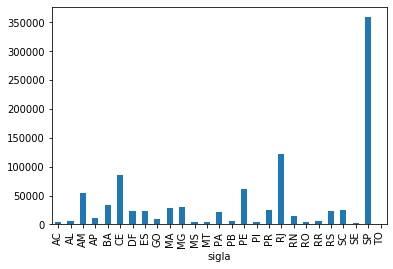

In [65]:
estados =dados.groupby('sigla')
acumuladodia= estados.casosAcumulados.sum()
acumuladodia.plot(kind='bar')

In [66]:
#api_br_io[ (api_br_io.state == 'RS')]

In [68]:
dataRS =api_br_io[ api_br_io.city.notnull() ]
rs = dataRS [ (dataRS.state == 'RS')&(dataRS.date == '2020-04-29') & (dataRS.place_type =='city')].sort_values(by='confirmed',ascending=False)
rs.groupby(['city'] )
rs.fillna(0, inplace = True)
fig = go.Figure(data=[go.Table(
    header=dict(values=['Cidades  % '+ str(round(rs.city.size*100/497,2)) +'<br><b>Total--</b>'+str(rs.city.size) +'</br>' ,
                        '<br>Confirmados</br> <b>Total-</b>'+ str(rs.confirmed.sum()),
                        '<br>Mortes</br>  <b>Total-</b>'+ str(rs.deaths.sum().astype(int))],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[rs.city, rs.confirmed,rs.deaths],
               fill_color='lavender',
               align='left'))
])

fig.show()
plotly.offline.plot(fig, filename='HTML/TabelaCovid19RS.html', auto_open=False)

'HTML/TabelaCovid19RS.html'

In [69]:
#![Tabela1 casos confirmados por cidades do RS](IMG/Alegrete.jpg)

In [70]:
import plotly.express as px


fig = px.bar(rs.head(10), y='city', x='confirmed',color='deaths', text='confirmed',orientation='h')

fig.update_traces( textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [71]:
#![Figura4 Acumulado dos casos no RS e óbitos](IMG/RS.jpg)

In [197]:
import codecs
br_estados = 'DB/br_states.json'
geo_json_data = json.load(codecs.open(br_estados, 'r', 'utf-8'))
covid_cidades= cidades.copy()
covid_estados= estados_brasil.copy()
df_bsb =covid_cidades[( covid_cidades.city.notnull()) & (covid_cidades.place_type =='city') ]
#df_estados =covid_estados[( covid_estados.city.notnull()) & (covid_estados.place_type =='city')& (covid_estados.state =='RS') ]
teste = cidades[['state','confirmed','deaths','death_rate']].groupby(cidades['state']).sum()
df_estados = estados_brasil.drop(['capital'], axis=1 ).merge(teste, on='state')


#cidades_captais= cidades[cidades.capital==1][['state','latitude','longitude','confirmed']]
#df_estados = estados_brasil.drop(['latitude','longitude', 'capital'], axis=1 ).merge(cidades_captais, on='state')
df_estados

,date,state,city,place_type,confirmed_x,deaths_x,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate_x,latitude,longitude,state_name,confirmed_y,deaths_y,death_rate_y
0,2020-04-30,AL,Maceió,city,853,32,True,1018948.0,2704302,83.71379,0.0375,-9.665990,-35.7350,Alagoas,1034,45,8.3542
1,2020-04-30,AP,Macapá,city,827,26,True,503327.0,1600303,164.30670,0.0314,0.034934,-51.0694,Amapá,1080,34,0.1636
2,2020-04-30,PA,Belém,city,1605,129,True,1492745.0,1501402,107.52004,0.0804,-1.455400,-48.4898,Pará,2876,208,7.8567
3,2020-04-29,AC,Rio Branco,city,300,17,True,407319.0,1200401,73.65235,0.0567,-9.974990,-67.8243,Acre,354,18,0.0967
4,2020-04-29,AM,Manaus,city,3091,288,True,2182763.0,1302603,141.60951,0.0932,-3.118660,-60.0212,Amazonas,4801,380,2.4779
5,2020-04-29,BA,Salvador,city,1645,62,True,2872347.0,2927408,57.27024,0.0377,-12.971800,-38.5011,Bahia,2658,99,8.8414
6,2020-04-29,CE,Fortaleza,city,5712,349,True,2669342.0,2304400,213.98532,0.0611,-3.716640,-38.5423,Ceará,7379,449,13.3502
7,2020-04-29,DF,Brasília,city,1237,28,True,3015268.0,5300108,41.02455,0.0226,-15.779500,-47.9297,Distrito Federal,1237,28,0.0226
8,2020-04-29,ES,Vitória,city,526,15,True,362097.0,3205309,145.26494,0.0285,-20.315500,-40.3128,Espírito Santo,2433,83,0.8663
9,2020-04-29,GO,Goiânia,city,404,12,True,1516113.0,5208707,26.64709,0.0297,-16.686400,-49.2643,Goiás,703,26,1.9767


In [189]:
from folium.plugins import MarkerCluster

In [203]:

#icon_path = 'IMG/icon.png'
#icon = folium.features.CustomIcon(icon_image=icon_path ,icon_size=(50,50))
brasil = folium.Map(location=[-15.77972, -47.92972], tiles='OpenStreetMap',zoom_start=4)


for _, dados in df_bsb.iterrows():
    
    html = """
    <h1> """+ dados.city + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str(dados.death_rate) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """
    
    if (dados['confirmed']>=1) & (dados['confirmed']<50):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=30000,
        color='green',
        stroke= False,
        fill=True,
        fill_color='green'
        ).add_to(brasil)
 
    if (dados['confirmed']>=50) & ( dados['confirmed']<100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='yellow',
        stroke= False,
        fill=True,
        fill_color='yellow'
        ).add_to(brasil)
 
    if (dados['confirmed']>=100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='red',
        stroke= False,
        fill=True,
        fill_color='red'
        ).add_to(brasil)

stategeo = folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: { 
         
        'fillColor': 'darkred',
        'color': 'darkred',
        'weight': 0.5,
    }
).add_to(brasil)
        
statesearch = Search(
    layer=stategeo,
    geom_type='Polygon',
    placeholder='Pesquisar Estado',
    collapsed=False,
    search_label='name',
    weight=3
).add_to(brasil)


folium.LayerControl().add_to(brasil)
brasil.save('HTML/MapaBrasilCovid19.html')


In [201]:
#icon_path = 'IMG/icon.png'
#icon = folium.features.CustomIcon(icon_image=icon_path ,icon_size=(50,50))
brasil = folium.Map(location=[-15.77972, -47.92972], tiles='OpenStreetMap',zoom_start=4)


for _, dados in df_estados.iterrows():
    
    html = """
    <h1> """+ dados.state_name + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed_y) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths_y) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str(dados.death_rate_y) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """
    
    if (dados['confirmed_y']>=1) & (dados['confirmed_y']<50):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='green',
        stroke= False,
        fill=True,
        fill_color='green'
        ).add_to(brasil)
 
    if (dados['confirmed_y']>=50) & ( dados['confirmed_y']<100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='yellow',
        stroke= False,
        fill=True,
        fill_color='yellow'
        ).add_to(brasil)
 
    if (dados['confirmed_y']>=100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='red',
        stroke= False,
        fill=True,
        fill_color='red'
        ).add_to(brasil)

stategeo = folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: { 
         
        'fillColor': 'darkred',
        'color': 'darkred',
        'weight': 0.5,
    }
).add_to(brasil)
        
statesearch = Search(
    layer=stategeo,
    geom_type='Polygon',
    placeholder='Pesquisar Estado',
    collapsed=False,
    search_label='name',
    weight=3
).add_to(brasil)


folium.LayerControl().add_to(brasil)
brasil.save('HTML/MapaBrasilEstadosCovid19.html')

In [76]:
#![Figura6 casos no RS ](IMG/RScasosDISTRI.jpg)

In [77]:
from datetime import datetime
now = datetime.now()

In [78]:
#hack ministério da saéde
print (str(now.year)+str(now.month)+str(now.day))



2020430


In [115]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, Circle

watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)

m = Map( center=(-15.77972, -47.92972),zoom=4)
for _, dados in df_bsb.iterrows():
    circle = Circle()
circle.location = (dados['latitude'], dados['longitude'])
circle.radius = 50000
circle.color = "green"
circle.fill_color = "green"
circle.stroke= False

m.add_layer(circle)

m

Map(center=[-15.77972, -47.92972], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

date                              2020-04-28
state                                     SE
city                                 Umbaúba
place_type                              city
confirmed                                  1
deaths                                     0
is_last                                 True
estimated_population_2019              25294
city_ibge_code                       2807600
confirmed_per_100k_inhabitants       3.95351
death_rate                                 0
latitude                            -11.3809
longitude                           -37.6623
capital                                    0
state_name                           Sergipe
Name: 3932, dtype: object


In [33]:
def sir_model(y, t, beta, gamma):
    S, I, R = y
    
    dS_dt = -beta*S*I
    dI_dt = beta*S*I - gamma*I
    dR_dt = gamma*I
    
    return [dS_dt, dI_dt, dR_dt]

In [34]:

import scipy.integrate
import numpy
# Total população, N.
N = 209.5*10**6 
#Número inicial de indivíduos infectados e recuperados, I0 e R0.
I0, R0 = 71886, 32544
#Todos os outros, S0, são suscetíveis à infecção inicialmente.
S0 = N - I0 - R0
# Taxa de contato, beta e taxa de recuperação média, gama, (em 1 / dias).
beta, gamma = 1.1, 1/5.2 
# Uma grade de pontos no tempo (em dias)

t = np.linspace(0, 160, 160)

# condições iniciais
S0 = 0.9
I0 = 0.1
R0 = 0.0
beta = 0.35
gamma = 0.1

# Time vector
t = numpy.linspace(0, 100, 10000)

# Result
solucao = scipy.integrate.odeint(sir_model, [S0, I0, R0], t, args=(beta, gamma))
solucao = numpy.array(solucao)

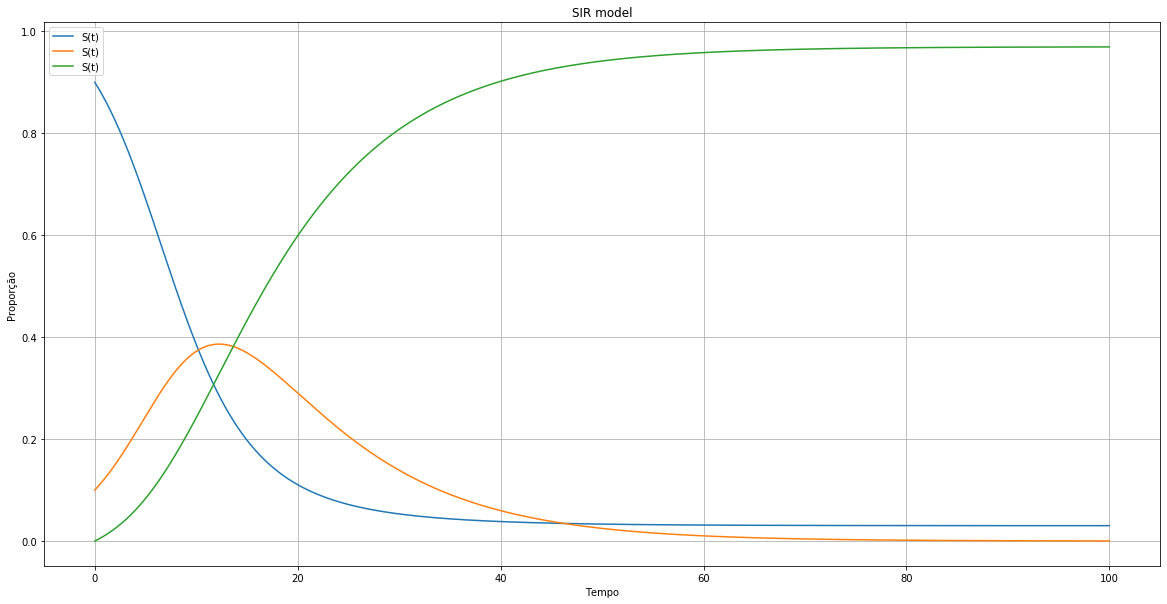

In [35]:

plt.figure(figsize=[20,10])
plt.plot(t, solucao[:, 0], label="S(t)")
plt.plot(t, solucao[:, 1], label="S(t)")
plt.plot(t, solucao[:, 2], label="S(t)")
plt.grid()
plt.legend()
plt.xlabel("Tempo")
plt.ylabel("Proporção")
plt.title("SIR model")

plt.show()

In [36]:
N = 209.5*10**6
N

209500000.0

In [90]:
!pip install ipyleaflet